In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
imNum = 1   # счётчик для названий картинок
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (12, 9)
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [22]:
#ВВод данных
df = pd.read_excel("conducting.ods", engine="odf") # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
df.iloc[:10, 0].dropna()
df.head()

,"Vэ, мВ","Vн, мВ","Q, мВт","R, $\Omega$",Unnamed: 4,"Vэ, мВ.1","Vн, мВ.1","Q, мВт.1","R, $\Omega$.1",Unnamed: 9,"Vэ, мВ.2","Vн, мВ.2","Q, мВт.2","R, $\Omega$.2",Unnamed: 14,"Vэ, мВ.3","Vн, мВ.3","Q, мВт.3","R, $\Omega$.3"
0,1.219,2.04,0.000249,16.735029,NaN,70.18,121.5,0.852687,17.312625,NaN,76.6,137.0,1.04942,17.885117,NaN,76.5,150.0,1.147500,19.607843
1,162.620,273.40,4.446031,16.812200,NaN,286.35,504.7,14.452084,17.625284,NaN,350.3,670.0,23.47010,19.126463,NaN,343.5,763.0,26.209050,22.212518
2,239.540,403.70,9.670230,16.853135,NaN,369.60,659.8,24.386208,17.851732,NaN,480.6,945.0,45.41670,19.662921,NaN,470.3,1032.0,48.534960,21.943440
3,339.950,575.42,19.561403,16.926607,NaN,423.25,760.9,32.205092,17.977555,NaN,577.5,1137.0,65.66175,19.688312,NaN,566.4,1212.8,68.692992,21.412429
4,439.060,747.75,32.830711,17.030702,NaN,467.60,846.0,39.558960,18.092387,NaN,670.1,1281.0,85.83981,19.116550,NaN,655.5,1358.5,89.049675,20.724638


In [25]:
# параметры построения графика и аппроксмации
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = False
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{мВт}{\Omega}$
b, мВт
'''
xname, xunit = r"$x$", "см"
yname, yunit = r"$y$", "кг"
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

6.954391556415417 +- 15.606946121932854
-95.24376971643194 +- 323.733351162754


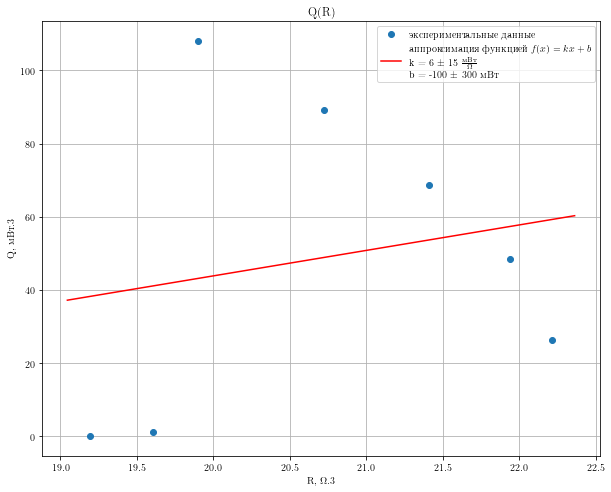

In [26]:
# построение графика

# опциональная загрузка данных разных измерений
N = 3 # номер измерения
stride = 5
x = df.iloc[:, stride*N+3].dropna()
y = df.iloc[:, stride*N+2].dropna()
xerr = np.ones_like(x)*0.01
yerr = np.ones_like(x)*0.01

xname, xunit = x.name.split(', ')
yname, yunit = y.name.split(', ')

if hasErrors:
    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
else:
    popt, pcov = curve_fit(f, x, y)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.figure(figsize=(10, 8))
if hasErrors:
    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
else:
    plt.plot(x, y, "o", label="экспериментальные данные")
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1